<a href="https://colab.research.google.com/github/DavidMcK9509/spotify-workshop/blob/master/Spotify_Workshop_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starting off 

##### Try out the following commands in the code block below, replacing the "____________" sections with your code

1.   print("Hello World) 

1.   name = "My name"
2.   print(name)

2.   print(5 * 10)

If your code isn't running make sure you have pressed "Connect" in the top right hand corner

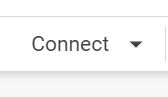



In [2]:
print("Hello World") # print("Hello World")
#Make sure you remember the speech marks and don't capatalise the p of print!

Hello World


In [3]:
name = "David" #name = "My name" 
print(name) #type print(name)

David


In [4]:
print(5*10) #print(5*10)

50


# Day 1

## Setup

### Package Import

In [8]:
# Install external packages for Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install rasterfairy-py3 spotipy umap-learn -q

###### **<font color='blue'>TO DO 1</font> :** import the `Image` module from the `PIL` package

In [5]:
# Import packages
from getpass import getpass        # secure text entry
from io import BytesIO             # reading binary data
from IPython.display \
  import clear_output              # clearing cell output
from sklearn.preprocessing \
  import StandardScaler            # feature standardisation
# TODO 01 Import the Image module from the PIL package
# (remember: exact capitalisation matters!)
from PIL import Image                    # image export 

###### **<font color='blue'>TO DO 2</font> :** import the spotify package

In [11]:
import numpy as np                 # mathematics
import os                          # setting environment variables
import pandas as pd                # storing audio features as dataframe
import plotly.express as px        # basic interactive visualisation
import plotly.graph_objects as go  # advanced plotting functionality
import rasterfairy                 # rasterfying point clouds
import requests                    # web requests
import spotipy                 # Python interface to Spotify API
import umap                        # dimensionality reduction

### Parameters

###### **<font color='blue'>TO DO 3</font> :** assign your username to the variable 'USERNAME'


In [6]:
# Parameters
# NB: Use 'mkprtr' for playlists from AZ Code Club
# TODO 03: supply a username
USERNAME = '1114316136'  # user to extract public playlists from
RESOLUTION = 2  # 0 (extreme); 1 (high); 2 (low)
ORIENTATION = 'landscape'  # landscape; portrait
MIN_RATIO = 0.5  # minimum ratio between shortest and longest dimension

In [7]:
# CKPT: Use `print(USERNAME)` to check that the username has been set correctly
print(USERNAME)

1114316136


### Helper Functions
#### You don't need to look at this but feel free if you are interested. Remember to run it though! 

In [9]:
# Define helper functions
def depaginate(first_page):
  """
  Flatten the paginated response from the Spotify API.
  
  The Spotify API returns responses over a certain size using pagination (like
  how Google has multiple page of results). This function takes the first page
  of a response and uses this to run through all other pages and return the
  page items in a flattened format.
  """
  page = first_page
  while page:
    for item in page['items']:
      yield item
    page = sp.next(page)

def resolution_map(resolution):
  """Return the pixel value corresponding to different resolution levels."""
  return [600, 300, 64][resolution]

def mel_to_harm(key):
  """Convert absolute keys to positions relative to the circle of fifths."""
  return (key * 7) % 12

def create_hover_text(track_df, features=None):
  """
  Create hover text for plots.
  
  Omit the second argument to leave out extra hover text for audio features.
  """
  text = (
      "Name: " + track_df['name'] + "<br>" +
      "Artist: " + track_df['artist'] + "<br>" +
      "Album: " + track_df['album'] + "<br><extra>"
  )
  if features:
    for f in features:
      text = text + f + ": " + track_df[f].apply(str) + "<br>"
  return text + "</extra>"

def find_valid_sample_count(track_df, min_ratio):
  """
  Find a sample count that can form a rectangle satisfying a minimum ratio.

  For difficult numbers of observations (e.g. a prime), only long rectangles
  can be formed in the final visualisation. We therefore keep decreasing the
  number of points until we have form a rectangle that satisfies a minimum
  ratio between side lengths.
  """
  n = len(track_df)
  found_solution = False
  while not found_solution:
    i, j = rasterfairy.getRectArrangements(n)[0]
    if i / j >= MIN_RATIO:
      found_solution = True
    else:
      n -= 1
  return n

### API (Application Programming Interface) Connection
#### Set-up a connection between Python and Spotify

###### **<font color='blue'>TO DO 4</font> :** add a line asking for the client secret and assign it to the `SPOTIPY_CLIENT_SECRET` environment variable (base client ID line bellow)
If you don't have your client ID and client Secret use:

Client ID - 460a1a32216c4e8f9bdf5c236975bf13

Client Secret - 851c13e3aa544cfd85a0a06e43f8cd70

In [13]:
# Authentication environment variables
overwrite_existing = False  # set to True to overwrite existing values
if overwrite_existing or 'SPOTIPY_CLIENT_ID' not in os.environ \
    or 'SPOTIPY_CLIENT_SECRET' not in os.environ:
  # NB: the input passed to `getpass` is the question asked to the user
  # `\n` means create a newline before creating the answer box
  os.environ['SPOTIPY_CLIENT_ID'] = getpass("What is your client ID?\n")
  # TODO 04: ask for the client secret and assign it to the
  # `SPOTIPY_CLIENT_SECRET` environment variable (base this on the line above)
  os.environ['SPOTIPY_CLIENT_SECRET'] = getpass("What is your client ID?\n")

What is your client ID?
··········
What is your client ID?
··········


In [14]:
# Initialise client
auth_manager = spotipy.SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

In [15]:
# CKPT: Run `sp.categories(country='GB', limit=3)` to list the first three
# categories in Great Britain. NB: This returns a dictionary with more
# dictionaries and lists nested inside
sp.categories(country= "GB", limit=3)

{'categories': {'href': 'https://api.spotify.com/v1/browse/categories?country=GB&offset=0&limit=3',
  'items': [{'href': 'https://api.spotify.com/v1/browse/categories/toplists',
    'icons': [{'height': 275,
      'url': 'https://t.scdn.co/media/derived/toplists_11160599e6a04ac5d6f2757f5511778f_0_0_275_275.jpg',
      'width': 275}],
    'id': 'toplists',
    'name': 'Top Lists'},
   {'href': 'https://api.spotify.com/v1/browse/categories/blackhistorymonth',
    'icons': [{'height': None,
      'url': 'https://t.scdn.co/images/9b0fe809ec654ed9b3b8257e31739d8f.jpeg',
      'width': None}],
    'id': 'blackhistorymonth',
    'name': 'Black History Is Now'},
   {'href': 'https://api.spotify.com/v1/browse/categories/pop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
      'width': 274}],
    'id': 'pop',
    'name': 'Pop'}],
  'limit': 3,
  'next': 'https://api.spotify.com/v1/browse/categories?coun

## Data Scraping

### Collect Playlists

In [16]:
# Create list to store key playlist information
playlist_info = []

###### **<font color='blue'>TO DO 5</font> :** add the `id` field to the playlist information below

In [17]:
# Loop through all playlists
for playlist in depaginate(sp.user_playlists(USERNAME)):
  # Add playlist information to list
  playlist_info.append({
      'name': playlist['name'],
      'size': playlist['tracks']['total'],
      # TODO 05: add the `id` field to the playlist information
      # This will look very similar to 'name' above
      'id' :playlist['id'],
  })

In [18]:
# CKPT: What does `playlist_info` look like? Use `print()` to find out
playlist_info

[{'id': '0cH0RwsK2ydecLy8WGtf37', 'name': 'Lonley running', 'size': 100},
 {'id': '6po3h7FILSGzMhemHNzNqG', 'name': '20 minute 5km', 'size': 3},
 {'id': '6S8LCGvoWfxDaq8sNriFZR', 'name': 'SUMC Vintage', 'size': 237},
 {'id': '2WxKtlKNDIRQerYsX8prmZ',
  'name': 'Tripy tunes for driving to the mountains',
  'size': 33},
 {'id': '2kTx8Gcu1qrBQEBSRos6qz',
  'name': 'Your standard everyday playlist',
  'size': 23},
 {'id': '3QMeu4Xs3lc33zvoH9V6v9', 'name': 'SUMC', 'size': 164},
 {'id': '43iVqJXqxmanNWz8Pw7s9x', 'name': 'California love', 'size': 72},
 {'id': '1oreetevYpKL9LGDU1TeXH', 'name': "yea i'm G", 'size': 148},
 {'id': '3WBdXpmonULsRX9W0NIkzQ', 'name': 'CHEESE', 'size': 149},
 {'id': '6LNfx95vKBju6dXpaWgArB',
  'name': 'Ultimate Power play list',
  'size': 27},
 {'id': '2WvvAK7KibNIlVJi2YJxIe', 'name': 'Pre-Game', 'size': 28},
 {'id': '5scqE4L8CT19xqPlJBwRIG', 'name': 'feel', 'size': 130}]

In [19]:
# Display playlist choices
max_digits = len(str(len(playlist_info)))
for i, info in enumerate(playlist_info):
  print(f"({str(i).zfill(max_digits)}) {info['name']} [{info['size']} tracks]")

(00) Lonley running [100 tracks]
(01) 20 minute 5km [3 tracks]
(02) SUMC Vintage [237 tracks]
(03) Tripy tunes for driving to the mountains [33 tracks]
(04) Your standard everyday playlist [23 tracks]
(05) SUMC [164 tracks]
(06) California love [72 tracks]
(07) yea i'm G [148 tracks]
(08) CHEESE [149 tracks]
(09) Ultimate Power play list [27 tracks]
(10) Pre-Game [28 tracks]
(11) feel [130 tracks]


### Playlist Selection

In [20]:
# Get user to select a playlist
valid = False  # placeholder to start off loop

while not valid:
  # Ask user for input
  choice_idx = input("Select a playlist index from the list above:\n")
  # Check if the input was valid
  valid = choice_idx.isnumeric() and 0 < int(choice_idx) <= len(playlist_info)
  if not valid:
    clear_output(wait=True)
    print(f"Selection must be an integer between 1 and {len(playlist_info)}")

# Python returns input as text so convert to an integer
choice_idx = int(choice_idx)
print(f"\nYou selected '{playlist_info[choice_idx-1]['name']}'")

Select a playlist index from the list above:
1

You selected 'Lonley running'


### Collect Tracks Details

###### **<font color='blue'>TO DO 6</font> :** create an empty list called `track_info` (see Collect Playlists)

In [23]:
# Get the ID of the choosen playlist
choice_id = playlist_info[choice_idx-1]['id']
# Create list to store key playlist information
# TODO 06: create an empty list called `track_info` (see Collect Playlists)
track_info = []

# Loop through all playlist items
for item in depaginate(sp.playlist_items(choice_id)):
  # Extract track information, ignoring item metadata (e.g. date added)
  track = item['track']
  track_info.append({
      'name': track['name'],
      'artist': track['artists'][0]['name'],
      'album': track['album']['name'],
      # NB: some tracks are missing artworks for all/some resolutions. If this
      # is an issue, the simplest solution is to remove them from the playlist
      'art_url': track['album']['images'][RESOLUTION]['url'],
      'id': track['id'],
  })

In [25]:
# CKPT: `track_info` might be quite a big object. Print out the second entry
# using `print(track_info[1])` (remember that we start from zero!)
print(track_info[1])

{'name': 'Summer', 'artist': 'Elephant Sessions', 'album': 'All We Have Is Now', 'art_url': 'https://i.scdn.co/image/ab67616d000048513fbf03630ae76fb9bf054a77', 'id': '5sYgYE65al4ryp2yNSefUD'}


# Day 2

### Collect Audio Features

###### **<font color='blue'>TO DO 7</font> :** add valence and tempo to the end of the list of included features

In [26]:
# List features to collect. See: https://spoti.fi/2Rhrtye
# TODO 07: add valence and tempo to the end of the list of included features
included = (
    'duration_ms', 'key', 'mode', 'time_signature',
    'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
    'loudness', 'speechiness', 'valence', 'tempo', 
)


In [27]:
# Audio feature requests have to be performed in batches of at most 100 IDs
for offset in range(0, len(track_info), 100):
  # Collect all features
  features = sp.audio_features(t['id'] for t in track_info[offset:offset+100])
  # Filter to only include the features listed above
  features = [{k: v for k, v in t.items() if k in included} for t in features]
  # Add features to track info
  for i in range(min(100, len(track_info) - offset)):
    track_info[i + offset].update(features[i])

In [28]:
# CKPT: Check the second element of `track_info` again to see the additions
print(track_info[1])

{'name': 'Summer', 'artist': 'Elephant Sessions', 'album': 'All We Have Is Now', 'art_url': 'https://i.scdn.co/image/ab67616d000048513fbf03630ae76fb9bf054a77', 'id': '5sYgYE65al4ryp2yNSefUD', 'danceability': 0.602, 'energy': 0.671, 'key': 1, 'loudness': -7.488, 'mode': 0, 'speechiness': 0.0318, 'acousticness': 0.213, 'instrumentalness': 0.00358, 'liveness': 0.109, 'valence': 0.272, 'tempo': 108.092, 'duration_ms': 314208, 'time_signature': 4}


In [31]:
# Convert to dataframe
track_df = pd.DataFrame(track_info)

In [32]:
# CKPT: Use `track_df.head()` to see the first few rows of the dataframe
# Can you remember how to see the last few rows?
track_df.head()

,name,artist,album,art_url,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Wet Field Day,Elephant Sessions,All We Have Is Now,https://i.scdn.co/image/ab67616d000048513fbf03...,6rGZSWD3J3Rt6RimdPYNil,0.645,0.785,11,-6.601,0,0.0282,0.165000,0.03850,0.0873,0.961,128.996,294597,4
1,Summer,Elephant Sessions,All We Have Is Now,https://i.scdn.co/image/ab67616d000048513fbf03...,5sYgYE65al4ryp2yNSefUD,0.602,0.671,1,-7.488,0,0.0318,0.213000,0.00358,0.1090,0.272,108.092,314208,4
2,Catriona's,Rura,In Praise of Home,https://i.scdn.co/image/ab67616d00004851afcb7e...,4xQnsExKUq7QD4ixBu5cJx,0.527,0.471,8,-11.411,1,0.0349,0.320000,0.95400,0.1500,0.350,105.024,321090,4
3,Day One,Rura,In Praise of Home,https://i.scdn.co/image/ab67616d00004851afcb7e...,1PwJhD1Y652UbAqbNVjQef,0.447,0.842,8,-9.291,1,0.0425,0.000022,0.93100,0.1080,0.168,124.144,202550,4
4,Spiders,Peatbog Faeries,Blackhouse,https://i.scdn.co/image/ab67616d0000485150a46c...,7huoQ5BV5Iwu53s1hpW6Hh,0.537,0.987,6,-8.967,0,0.0483,0.001250,0.91500,0.1410,0.312,120.035,318693,4


## Pre-processing

### Sampling

###### **<font color='blue'>TO DO 8</font> :** find n, the maximum valid sample count by running the `find_valid_sample_count(...)` function with the two arguments `track_df`and `MIN_RATIO` (separate the arguments with a comma)

In [33]:
# Find a sample count that satisfies the minimum ratio
# TODO 08: find n, the maximum valid sample count by running the
# `find_valid_sample_count(...)` function with the two arguments `track_df`
# and `MIN_RATIO` (separate the arguments with a comma)
n = find_valid_sample_count(track_df, MIN_RATIO)

# Take random sample of chosen size
print(f"Randomly removing {len(track_df) - n} tracks to leave {n} remaining")
sampled_track_df = track_df.sample(n, random_state=1729).reset_index(drop=True)

Randomly removing 0 tracks to leave 100 remaining


In [36]:
# CKPT: Print the dimensions of `track_df` using `print(track_df.shape)`
# Do the same for `sampled_track_df` for comparison
print(track_df)
print(track_df.shape)

                                       name  ... time_signature
0                             Wet Field Day  ...              4
1                                    Summer  ...              4
2                                Catriona's  ...              4
3                                   Day One  ...              4
4                                   Spiders  ...              4
..                                      ...  ...            ...
95  Yorktown (The World Turned Upside Down)  ...              4
96                                 Non-Stop  ...              4
97                The Room Where It Happens  ...              4
98                        Cabinet Battle #2  ...              4
99                                    Takit  ...              4

[100 rows x 18 columns]
(100, 18)


###### **<font color='blue'>TO DO 9</font> :** drop the column containing the url for the cover art (see Collect Track Details to find its name)

In [39]:
# Extract feature columns into own dataframe
# TODO 09: drop the column containing the url for the cover art
# (see Collect Track Details to find its name)
features_df = sampled_track_df.drop(
    ['name', 'artist', 'album', 'art_url', 'id'], axis=1
)

In [42]:
# CKPT: Whereas `.shape` gives the dimensions, `.columns` gives us column
# names. Use this to print the columns of `features_df` and `sampled_track_df`
print(features_df.columns)
print(sampled_track_df.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')
Index(['name', 'artist', 'album', 'art_url', 'id', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')


### Feature Engineering
#### This code helps incorparate which key each song is in as a feature that determines where it goes on your visual

In [43]:
# Transform key from polar coordinates using melodic distance
features_df['key_melodic_x'] = np.cos(features_df['key'] / 6 * np.pi)
features_df['key_melodic_y'] = np.sin(features_df['key'] / 6 * np.pi)

# Transform key from polar coordinates using harmonic distance
features_df['key_harmonic'] = features_df['key'].apply(mel_to_harm)
features_df['key_harmonic_x'] = np.cos(features_df['key_harmonic'] / 6 * np.pi)
features_df['key_harmonic_y'] = np.sin(features_df['key_harmonic'] / 6 * np.pi)

# Remove redundant columns
features_df.drop(['key', 'key_harmonic'], axis=1, inplace=True)

# Handle missing keys
features_df.iloc[:,-4:].fillna(0, inplace=True)

### Standardisation

###### **<font color='blue'>TO DO 10</font> :**  use `features_df` as an input to the `.fit_transform` method of the StandardScaler to standardise the features

In [44]:
# TODO 10: use `features_df` as an input to the `.fit_transform` method of the
# StandardScaler to standardise the features
scaled_features = StandardScaler().fit_transform(features_df)

# Two features represent the key so weight these a factor of one fourth
scaled_features[:,-4:] /= 2

## Dimensionality Reduction
#### We currently have data in 16 dimensions! Lets reduce that to something more managable!

### Embedding

###### **<font color='blue'>TO DO 11</font> :**  Set initial hyperparameter values to be 10 for `n_neighbors` and 0.5 for `min_dist`

In [45]:
# Embedded the audio features into two dimensions
embedding = umap.UMAP(
    n_components=2,
    # Embedding hyperparameters used to balance local and global structure
    # See:
    #   https://pair-code.github.io/understanding-umap/
    #   https://umap-learn.readthedocs.io/en/latest/parameters.html
    # TODO 11: Set initial hyperparameter values to be 10 for `n_neighbors` and
    # 0.5 for `min_dist`
    n_neighbors = 10,
    min_dist = 0.5,
    metric='euclidean',
    # Random seed used for reproducibility
    random_state=1729).fit_transform(scaled_features)

###### **<font color='blue'>TO DO 12</font> :**  create a y variable alike the x variable below using the column with index 1

In [47]:
# View embedding
x = embedding[:, 0]
# TODO 12: use the column with index 1 for the y variable
y = embedding[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    hovertemplate = '%{text}',
    # Add `included` as a second argument to show audio features on hover
    text=create_hover_text(sampled_track_df, included)
))

fig.update_traces(mode='markers')

fig.show()

### Rasterfication

In [48]:
# Rasterfy embedding
grid, dims = rasterfairy.transformPointCloud2D(
    embedding[:, :], proportionThreshold=MIN_RATIO
)

# Fix grid type
grid = grid.astype(int)

# Fix orientation (portrait by default)
if ORIENTATION == 'portrait':
   pass
elif ORIENTATION == 'landscape':
  grid = grid[:, ::-1]
  dims = dims[::-1]
else:
  raise ValueError("invalid orientation")

###### **<font color='blue'>TO DO 13&14</font> :** plot markers rather than lines (see Embedding - TODO 12)

In [50]:
# View rasterfied embedding
x = grid[:, 0]
y = grid[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    hovertemplate = '%{text}',
    #Add 'included' as a second argument to show audio features on hover
    text=create_hover_text(sampled_track_df, included)
))

# TODO 13: plot markers rather than lines (again, see above)
fig.update_traces(mode="markers")

# TODO 14: show the plot
fig.show()

## Visualisation

### Create Image

###### **<font color='blue'>TO DO 15</font> :** create a variable `height` using the 2nd element of `dims`

In [51]:
# Covert resolution level to number of pixels
px = resolution_map(RESOLUTION)
width = px * dims[0]
# TODO 15: create a variable `height` using the 2nd element of `dims`
height = px *dims[1]

# Create empty grid to store cover art
art_grid = np.empty((height, width, 3))

for i, row in sampled_track_df.iterrows():
  res = requests.get(row['art_url'])
  img = Image.open(BytesIO(res.content))
  img = img.resize((px, px), Image.ANTIALIAS).convert('RGB')
  art_grid[px * grid[i, 1]:px * (grid[i, 1] + 1),
           px * grid[i, 0]:px * (grid[i, 0] + 1)] = np.array(img)

In [52]:
# Create empty grid to store cover art
art_grid = np.empty((height, width, 3))

for i, row in sampled_track_df.iterrows():
  res = requests.get(row['art_url'])
  img = Image.open(BytesIO(res.content))
  img = img.resize((px, px), Image.ANTIALIAS).convert('RGB')
  art_grid[px * grid[i, 1]:px * (grid[i, 1] + 1),
           px * grid[i, 0]:px * (grid[i, 0] + 1)] = np.array(img)

### Interactive Visualisation

###### **<font color='blue'>TO DO 16</font> :** further below set the y axis visibility and range (using `height`) alike what was done with x


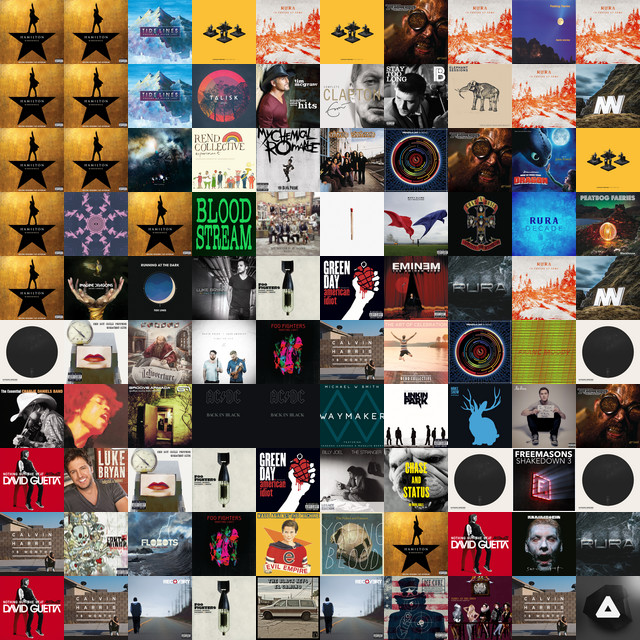

In [54]:
fig = go.Figure()

# Add invisible markers in the corners to help with autoscaling
fig.add_trace(go.Scatter(
    x=[0, width], y=[0, height],
    mode='markers', marker_opacity=0
))

# Add background image
fig.add_layout_image({
        'x': 0, 'sizex': width, 'xref': 'x',
        'y': height, 'sizey': height, 'yref': 'y',
        'opacity': 1.0, 'layer': 'below', 'sizing': 'stretch',
        # Images are plotted downwards so reverse first axis
        'source': Image.fromarray(art_grid.astype(np.uint8))
})

# Add labels through an invisible heatmap
x = [px // 2 + px * i for i in range(dims[0])]
y = [px // 2 + px * j for j in range(dims[1])]
# Add `included` as a second argument to show audio features on hover
hover_text = create_hover_text(sampled_track_df, included)
labels = np.empty(dims[::-1], dtype='object')
for i in range(len(sampled_track_df)):
    labels[dims[1] - 1 - grid[i, 1], grid[i, 0]] = hover_text[i]
z = np.random.uniform(size=dims[::-1])  # random values for invisible heatmap

fig.add_trace(go.Heatmap(
    x=x, y=y, z=z, hovertemplate = '%{text}', text=labels,
    opacity=0, showscale=False
))

fig.update_xaxes(
    visible=False,
    range=[0, width]
)
fig.update_yaxes(
    # TODO 16: set axis visibility to false and range (using `height`)
    # as was done with the x-axis above
    visible = False,
    range = [0, height],
    # Fix aspect ratio
    scaleanchor='x'
)

fig.update_layout(
    width=width,
    height=height,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
    plot_bgcolor='black'
)

# Disable the autosize on double click because it adds unwanted margins
fig.show(config={'doubleClick': 'reset'})

### Image Export

In [ ]:
# Save image to files - download from the sidebar
Image.fromarray(art_grid.astype(np.uint8)).save('wall_of_music.png')